In [1]:
import ee
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ee.Initialize()

### Define basic parameters

In [3]:
# define the year range
year_range = [(f'{i}-01-01',f'{i+2}-12-31') for i in range(1990,2020,3)]

# import some spatial constrains
North_china_plain_boundary = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [4]:
year_range

[('1990-01-01', '1992-12-31'),
 ('1993-01-01', '1995-12-31'),
 ('1996-01-01', '1998-12-31'),
 ('1999-01-01', '2001-12-31'),
 ('2002-01-01', '2004-12-31'),
 ('2005-01-01', '2007-12-31'),
 ('2008-01-01', '2010-12-31'),
 ('2011-01-01', '2013-12-31'),
 ('2014-01-01', '2016-12-31'),
 ('2017-01-01', '2019-12-31')]

### Calculate the sample_point_num for each NDVI value

##### Step_1: Compute the histogram of NDVI for each Landsat image

In [4]:
NDVI_hist = {}
year_span = []


# reverse the year_range order so we process the latest year first
for span in year_range[::-1]:
    
    # create name variables from span
    start = span[0]
    end   = span[1]
    
    split = '-'
    span_name = f'{start.split(split)[0]}_{end.split(split)[0]}'
    
    year_span.append(span_name)
        
#     # Fetch the NDVI value 
#     NDVI = ee.Image(f'users/wensomone666/Jinzhu/Mean_NDVI/Year_{span_name}_Mean_NDVI').clip(North_china_plain_boundary)
    
#     # Calculate the area percentage of each NDVI value 
#     NDVI_frequency = NDVI.reduceRegion(reducer   = ee.Reducer.histogram(200),
#                                        geometry  = North_china_plain_boundary.geometry(), 
#                                        scale     = 30, 
#                                        maxPixels = int(1e13)).getInfo()
    
#     # unpack the value from histogram
#     count    = [round(i) for i in NDVI_frequency['nd']['histogram']]
#     nd_value = [round(i) for i in NDVI_frequency['nd']['bucketMeans']]
    
#     # put the hist value into the hist dictionary
#     NDVI_hist[span_name] = list(zip(nd_value,count))
    
    # print out the process
    print(f'Histogram calculation of Year_{span_name}_Mean_NDVI completed!')
    

Histogram calculation of Year_2017_2019_Mean_NDVI completed!
Histogram calculation of Year_2014_2016_Mean_NDVI completed!
Histogram calculation of Year_2011_2013_Mean_NDVI completed!
Histogram calculation of Year_2008_2010_Mean_NDVI completed!
Histogram calculation of Year_2005_2007_Mean_NDVI completed!
Histogram calculation of Year_2002_2004_Mean_NDVI completed!
Histogram calculation of Year_1999_2001_Mean_NDVI completed!
Histogram calculation of Year_1996_1998_Mean_NDVI completed!
Histogram calculation of Year_1993_1995_Mean_NDVI completed!
Histogram calculation of Year_1990_1992_Mean_NDVI completed!
Histogram calculation of Year_1987_1989_Mean_NDVI completed!


In [5]:
# innitilize an empyty datafram
NDVI_hist_df = pd.DataFrame()

for year_name, nd_freq in NDVI_hist.items():
    
    # Create a datafram to hold the histogram of this year_name
    tmp_df = pd.DataFrame(data=nd_freq,
                          index=[year_name]*len(nd_freq),
                          columns=['NDVI','Freq'])
    
    tmp_df['Select_num'] = tmp_df['Freq'].apply(lambda x: round(x*10000/(tmp_df['Freq'].sum())))
    
    # concate the tmp_df to 
    NDVI_hist_df = pd.concat([NDVI_hist_df,tmp_df])
    

In [6]:
# save the NDVI_hist_df to local disk
# NDVI_hist_df.index.name = 'Year_range'
# NDVI_hist_df.to_csv('./Result_df/NDVI_area_propotion.csv')

# load the NDVI_hist_df from locak disk
NDVI_hist_df = pd.read_csv('./Result_df/NDVI_area_propotion.csv')
NDVI_hist_df

,Year_range,NDVI,Freq,Select_num
0,2017_2019,-16,29,0.0
1,2017_2019,-15,141,0.0
2,2017_2019,-14,611,0.0
3,2017_2019,-13,2265,0.0
4,2017_2019,-12,4875,0.0
...,...,...,...,...
812,1987_1989,38,722,0.0
813,1987_1989,39,212,0.0
814,1987_1989,40,81,0.0
815,1987_1989,41,32,0.0


##### Step_2: Create 50K random sample point and extract NDVI value to it

In [7]:
# get each year_range and put them into list
date_range = NDVI_hist_df['Year_range'].unique()

# get each nd-freq tuple from each year_range
nd_freq = [list(zip(NDVI_hist_df[NDVI_hist_df['Year_range'] == idx]['NDVI'],
                    NDVI_hist_df[NDVI_hist_df['Year_range'] == idx]['Select_num'])) for idx in date_range]

# put year_range and corespoded nd-freq into a list
NDVI_select_num = list(zip(date_range,nd_freq))

In [8]:
Path = 'users/wangjinzhulala/North_China_Plain_Python/Sample_50K'

for year_name in year_range:
    
    # create name variables from span
    start = year_name[0]
    end   = year_name[1]
    
    split = '-'
    span_name = f'{start.split(split)[0]}_{end.split(split)[0]}'
    
    asset_name = f'Sample_50K_year_{span_name}'
    
    # fetch the NDVI img
    NDVI_img = ee.Image(f'users/wensomone666/Jinzhu/Mean_NDVI/Year_{span_name}_Mean_NDVI').clip(North_china_plain_boundary)
    
    # create 50K sample point
    Sample_50k = NDVI_img.sample(region = North_china_plain_boundary.geometry(),
                                 scale = 30,
                                 numPixels=50000,
                                 geometries = True)
    
    # export 
#     task = ee.batch.Export.table.toAsset(   collection  = Sample_50k,
#                                             description = f'Exporting {asset_name}',
#                                             assetId     = f'{Path}/{asset_name}')
#     task.start()
    
    # print out the process
    print(f'{asset_name} exprted sucessfully')

Sample_50K_year_1987_1989 exprted sucessfully
Sample_50K_year_1990_1992 exprted sucessfully
Sample_50K_year_1993_1995 exprted sucessfully
Sample_50K_year_1996_1998 exprted sucessfully
Sample_50K_year_1999_2001 exprted sucessfully
Sample_50K_year_2002_2004 exprted sucessfully
Sample_50K_year_2005_2007 exprted sucessfully
Sample_50K_year_2008_2010 exprted sucessfully
Sample_50K_year_2011_2013 exprted sucessfully
Sample_50K_year_2014_2016 exprted sucessfully
Sample_50K_year_2017_2019 exprted sucessfully


##### Compute the sample_select 

In [9]:
# fetch all 50K sample point
Sample_50k_point = [ee.FeatureCollection(f'{path}/Sample_50K_year_{year_name}')
                   for path in ['users/wangjinzhulala/North_China_Plain_Python/Sample_50K']
                   for year_name in year_span]

In [10]:
for year in year_span:
    
    NDVI = NDVI_hist_df[NDVI_hist_df['Year_range'] == year]['NDVI'].values
    Freq = NDVI_hist_df[NDVI_hist_df['Year_range'] == year]['Freq'].values
    Num  = NDVI_hist_df[NDVI_hist_df['Year_range'] == year]['Select_num'].values
    
    
    

In [12]:
# define the path to GEE-asset
path = 'users/wangjinzhulala/North_China_Plain_Python/Sample_50K'

# create an empty dict to hold the coordinates of selected points
Select_pts = {year:[] for year in NDVI_hist_df['Year_range'].unique()}


for index,row in NDVI_hist_df.iterrows():
    
    # get necessary variables
    year = row['Year_range']
    nd   = row['NDVI']
    freq = row['Freq']
    num  = row ['Select_num']
    
    # if the select_num <= 5, skip the sampling
    if num <= 5:
        print(f'{year} {nd} has less than 6 select points, so skip select at this NDVI value.')
        continue
    
#     # fetch the 50k sample
#     sample_50k        = ee.FeatureCollection(f'{path}/Sample_50K_year_{year}')
#     sample_50k_filter = sample_50k.filterMetadata('nd' ,'equals',nd)\
#                                   .randomColumn('x').sort('x').limit(num).getInfo()\
    
#     # unpack the coordinate
#     coors  = [pt['geometry']['coordinates'] for pt in sample_50k_filter['features']]
#     nd_val = [pt['properties']['nd']        for pt in sample_50k_filter['features']]
    
    
                                
#     # updata the coordinates dict
#     Select_pts[year].extend([[i[0] ]+ i[1] for i in zip(nd_val,coors)])
        
    # print out the process
    print(f'Year{year} NDVI {nd} coordinates unpacking sucessfully. Opts ==>{index + 1}/{len(NDVI_hist_df)}')

2017_2019 -16 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -15 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -14 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -13 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -12 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -11 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -10 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -9 has less than 6 select points, so skip select at this NDVI value.
2017_2019 -8 has less than 6 select points, so skip select at this NDVI value.
Year2017_2019 NDVI -7 coordinates unpacking sucessfully. Opts ==>10/817
Year2017_2019 NDVI -6 coordinates unpacking sucessfully. Opts ==>11/817
Year2017_2019 NDVI -5 coordinates unpacking sucessfully. Opts ==>12/817
Year2017_2019 NDVI -4 coordinates unpacking sucessfully. Opts ==>1

#####  Obseve the total point number 

In [13]:
# Select_pt = pd.DataFrame()

# for k,v in Select_pts.items(): 
    
#     # Create a temperary df of given year
#     idx  = [k] * len(v)
#     tmp_df = pd.DataFrame(data=v,index=idx,columns=['NDVI','Lon','Lat'])
    
#     # concate the temperaty df with main sample points df
#     Select_pt = pd.concat([Select_pt,tmp_df])
    
#     # print out the total sample number
#     print(f'{k} {len(v)}')
    
# # set index for the Select_pt
# Select_pt.index.name = 'Year_range'

# # save the sample_pt df to local drive
# Select_pt.to_csv('../GEE_sample_point/Sample_point.csv')

In [14]:
Select_pt = pd.read_csv('../GEE_sample_point/Sample_point.csv')
Select_pt

,Year_range,NDVI,Lon,Lat
0,2017_2019,-7,118.726836,33.254232
1,2017_2019,-7,121.540840,32.429080
2,2017_2019,-7,117.606939,38.966313
3,2017_2019,-7,118.759813,33.195824
4,2017_2019,-7,118.560615,33.246677
...,...,...,...,...
109804,1987_1989,29,115.456920,35.935714
109805,1987_1989,29,114.907823,35.592455
109806,1987_1989,29,115.047830,36.078850
109807,1987_1989,29,116.906433,34.792143


##### Oberserve the distribution between select_points and orginal NDVI-img

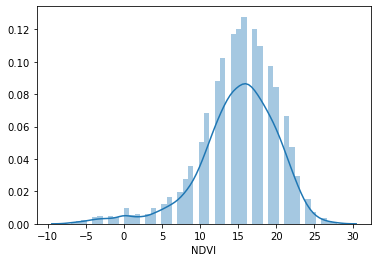

In [15]:
# plot the NDVI distribution of select_points
Select_2017_2019 = Select_pt[Select_pt['Year_range'] == '2017_2019']
sns.distplot(Select_2017_2019['NDVI'])

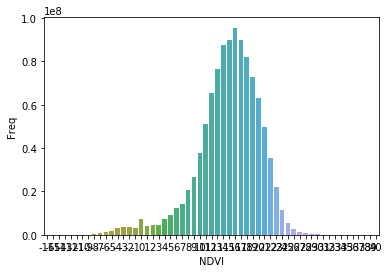

In [16]:
# plot the distribution of NDVI img
ND_hist_2017_2019 = NDVI_hist_df[NDVI_hist_df['Year_range'] == '2017_2019']
sns.barplot(x = 'NDVI', y ='Freq', data= ND_hist_2017_2019)